In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from PIL import Image

In [2]:
TRAIN_FOLDER = '../data/train_v2/'
TRAIN_MASK = '../data/train_ship_segmentations_v2.csv'
TEST_FOLDER = '../data/test_v2/'

IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
IMAGE_CHANNELS = 3

In [3]:
img_sizes = []
img_to_drop = []
for file in tqdm(os.listdir(TRAIN_FOLDER)):
    try:
        img = plt.imread(os.path.join(TRAIN_FOLDER, file))
        shape = img.shape
        if shape not in img_sizes:
            img_sizes.append(img.shape)
    except Exception as e:
        print(f'Cannot read image: {file}')
        img_to_drop.append(file)
        continue

if len(img_sizes) == 1:
    IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = img_sizes[0]
    print(f'All images have the same size: {img_sizes[0]}')
else:
    print(f'Images have different sizes: {img_sizes}')

print(img_to_drop)

100%|█████████████████████████████████████████████████████████████████████████| 192555/192555 [27:17<00:00, 117.60it/s]

All images have the same size: (768, 768, 3)
[]


### Luckily, we have all pictures with the same size. Let's try to provide the model with the same dimensionality of the images. Drop images that cannot be read.

In [16]:
for file in img_to_drop:
    os.remove(os.path.join(TRAIN_FOLDER, file))

#### Read the input data

In [5]:
train_df = pd.read_csv(TRAIN_MASK)
train_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


#### Display how many image with ships and how many image without ships

In [6]:
train_df['Ships'] = train_df['EncodedPixels'].map(lambda x: 1 if isinstance(x, str) else 0)
train_df

,ImageId,EncodedPixels,Ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
...,...,...,...
231718,fffedbb6b.jpg,NaN,0
231719,ffff2aa57.jpg,NaN,0
231720,ffff6e525.jpg,NaN,0
231721,ffffc50b4.jpg,NaN,0


### For pictures find the actual number/fraction part of pixel of ships

In [7]:
def get_pixels(encoded_pixels: str) -> int:
    if not isinstance(encoded_pixels, str):
        return 0
    else:
        return np.array(encoded_pixels.split()[1::2], dtype=int).sum()

train_df['ShipsArea'] = train_df.apply(lambda x: get_pixels(x['EncodedPixels']), axis=1)
train_df.head(10)

,ImageId,EncodedPixels,Ships,ShipsArea
0,00003e153.jpg,NaN,0,0
1,0001124c7.jpg,NaN,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1,3388
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1,177
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1,148
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1,480
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1,7
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...,1,648
8,0001b1832.jpg,NaN,0,0
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,1,400


In [8]:
ship_per_img = train_df.groupby('ImageId').agg({'Ships': 'sum', 'ShipsArea': 'sum'}).reset_index()
ship_per_img = ship_per_img.sort_values(by='Ships', ascending=False)
ship_per_img

,ImageId,Ships,ShipsArea
61000,5151bc5d2.jpg,15,988
65198,56d23b600.jpg,15,11033
69800,5ce0761c8.jpg,15,4239
95412,7ed6fd5e5.jpg,15,380
74031,626beb313.jpg,15,3198
...,...,...,...
72210,600680966.jpg,0,0
72211,6006df29c.jpg,0,0
72214,60079c8f7.jpg,0,0
72216,6008c43aa.jpg,0,0


In [9]:
ship_per_img['ShipPercentage'] = ship_per_img['ShipsArea'] / (IMAGE_WIDTH * IMAGE_HEIGHT) * 100
ship_per_img

,ImageId,Ships,ShipsArea,ShipPercentage
61000,5151bc5d2.jpg,15,988,0.167508
65198,56d23b600.jpg,15,11033,1.870558
69800,5ce0761c8.jpg,15,4239,0.718689
95412,7ed6fd5e5.jpg,15,380,0.064426
74031,626beb313.jpg,15,3198,0.542196
...,...,...,...,...
72210,600680966.jpg,0,0,0.000000
72211,6006df29c.jpg,0,0,0.000000
72214,60079c8f7.jpg,0,0,0.000000
72216,6008c43aa.jpg,0,0,0.000000


### Display ship number distribution 

In [10]:
ships = ship_per_img['Ships'].value_counts()
ships

0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: Ships, dtype: int64

Text(0.5, 1.0, 'Distribution number of ships')

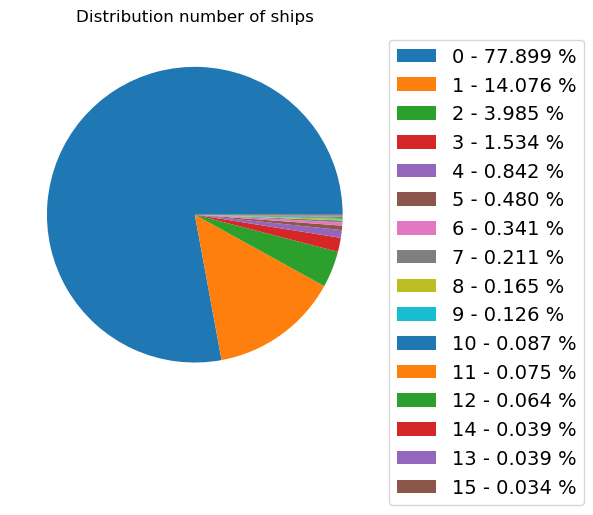

In [11]:
y = ships.values

labels = []
for i in range(len(ships.index)):
    percent = 100. * y[i] / y.sum()
    labels.append(f'{ships.index[i]} - {percent:.03f} %')

ships.plot.pie(labels=None)

plt.legend(labels, bbox_to_anchor=(1., 1.), fontsize=14)
plt.ylabel(None)
plt.title('Distribution number of ships')

### RLE decoding

In [12]:
def segmentation_mask(encoded_pixels: str):
    mask = np.zeros((IMAGE_WIDTH * IMAGE_HEIGHT))  

    encoded_pixels = encoded_pixels.split()
    start_pixels = np.array([(int(x) - 1) for x in encoded_pixels[::2]]) #to start from 0, not 1
    lengths = np.array([int(x) for x in encoded_pixels[1::2]])
    end_pixels = start_pixels + lengths
    
    for i in range(start_pixels.shape[0]):
        mask[start_pixels[i]:end_pixels[i]] = 1
    mask = mask.reshape(IMAGE_WIDTH, IMAGE_HEIGHT).T
    return mask


def get_encoded_pixels_by_img_id(img_id):    
    encoded_pixels = train_df[train_df['ImageId'] == img_id]['EncodedPixels']
    if pd.isna(encoded_pixels.values[0]):
        encoded_pixels = ' '
    encoded_pixels = ' '.join(encoded_pixels)
    
    return encoded_pixels


def display_image_with_segmentation(img_id):
    encoded_pixels = get_encoded_pixels_by_img_id(img_id)
    segmenation = segmentation_mask(encoded_pixels)

    img = np.asarray(Image.open(os.path.join(TRAIN_FOLDER, img_id)))
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    axes[0].imshow(img)
    axes[0].set_title("Image")

    axes[1].imshow(segmenation)
    axes[1].set_title("Segmentation Mask")

    plt.show()

# Image displaying
#### Image without any ships

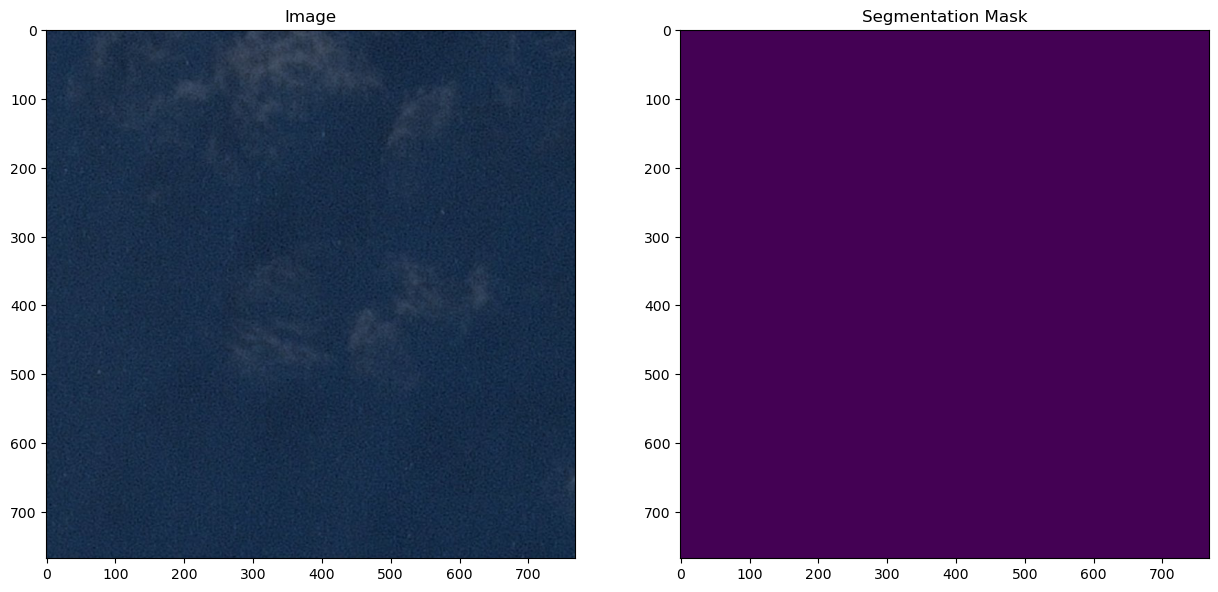

In [13]:
display_image_with_segmentation('00003e153.jpg')

#### Image with 1 ship

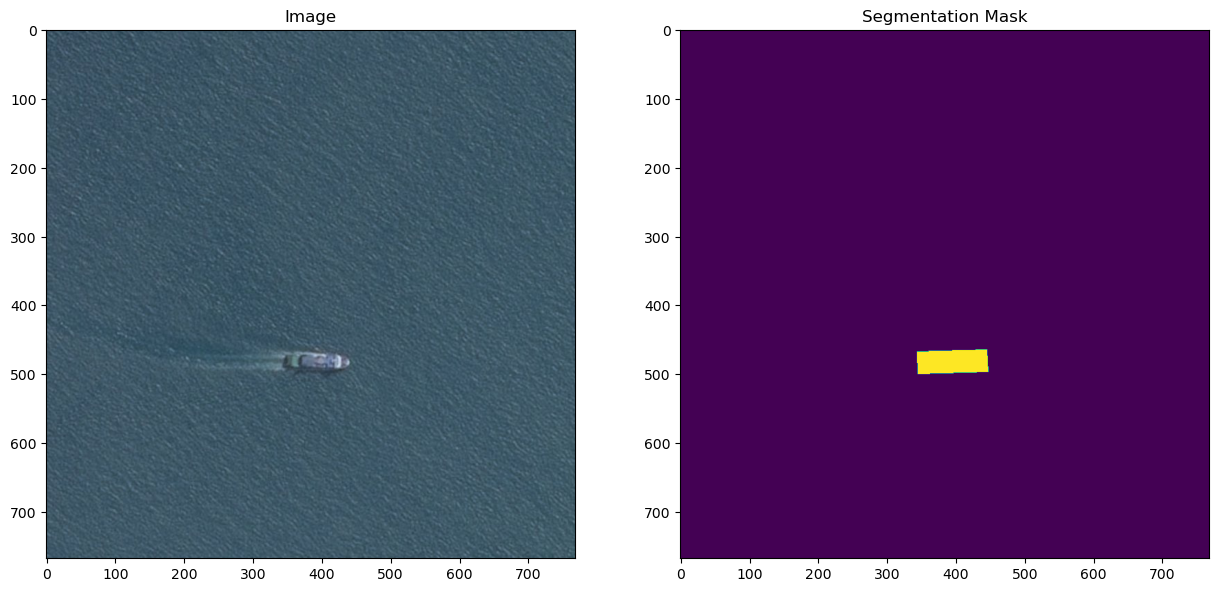

In [14]:
display_image_with_segmentation('000155de5.jpg')

#### Image with 2+ ships

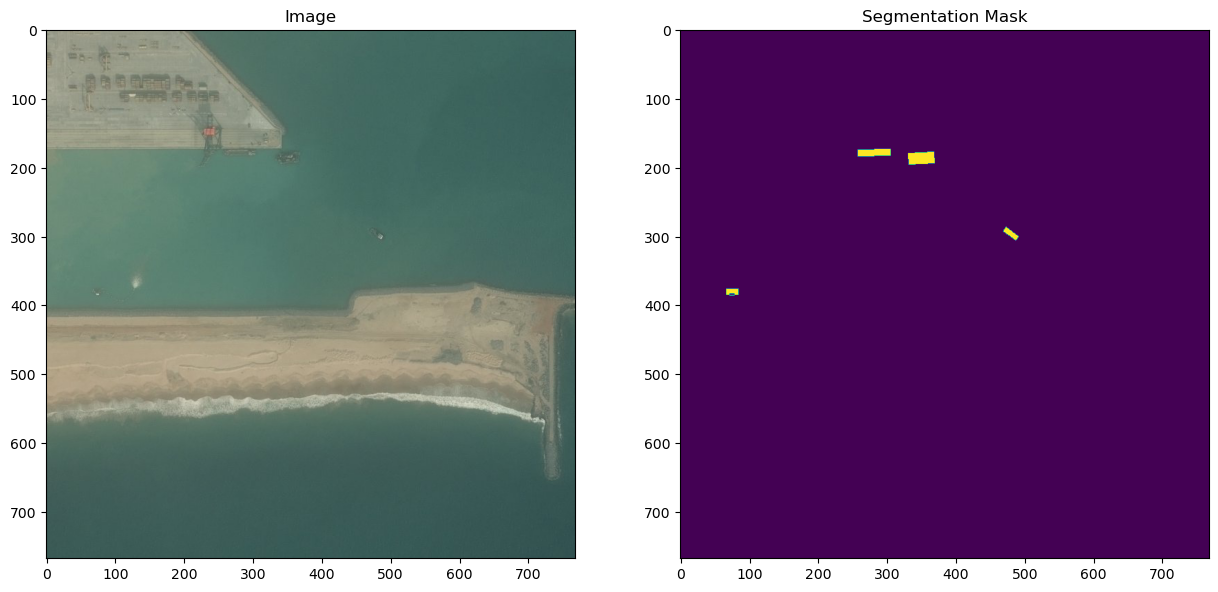

In [15]:
display_image_with_segmentation('000194a2d.jpg')